# Fully Connected Neural Networks Revisited

The main learning goal of this tutorial is to show that  Fully Connected Neural Networks are global in nature (i.e., fully connected .

In [3]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

## Load dataset, explore it  and split it into train, validation and test sets

- [Load MNIST Keras](https://keras.io/api/datasets/mnist/#load_data-function)

In [4]:
# Loading the data using the Keras function
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.mnist.load_data() # The data comes already split 
                                                                        # in dev and test sets
print("Development set")
print("Images: ",X_dev.shape)
print("Labels shape:",Y_dev.shape)
print("\nNumber of classes:",np.unique(Y_dev).size)
print("\nClasses:",np.unique(Y_dev))
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)

Development set
Images:  (60000, 28, 28)
Labels shape: (60000,)

Number of classes: 10

Classes: [0 1 2 3 4 5 6 7 8 9]

Test set
Images:  (10000, 28, 28)
Labels shape:  (10000,)


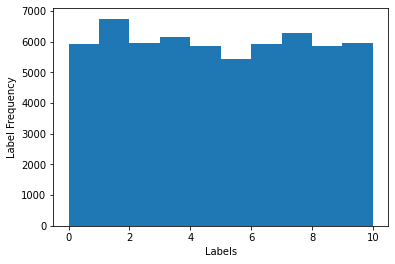

In [5]:
plt.figure()
plt.hist(Y_dev, bins = range(11))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

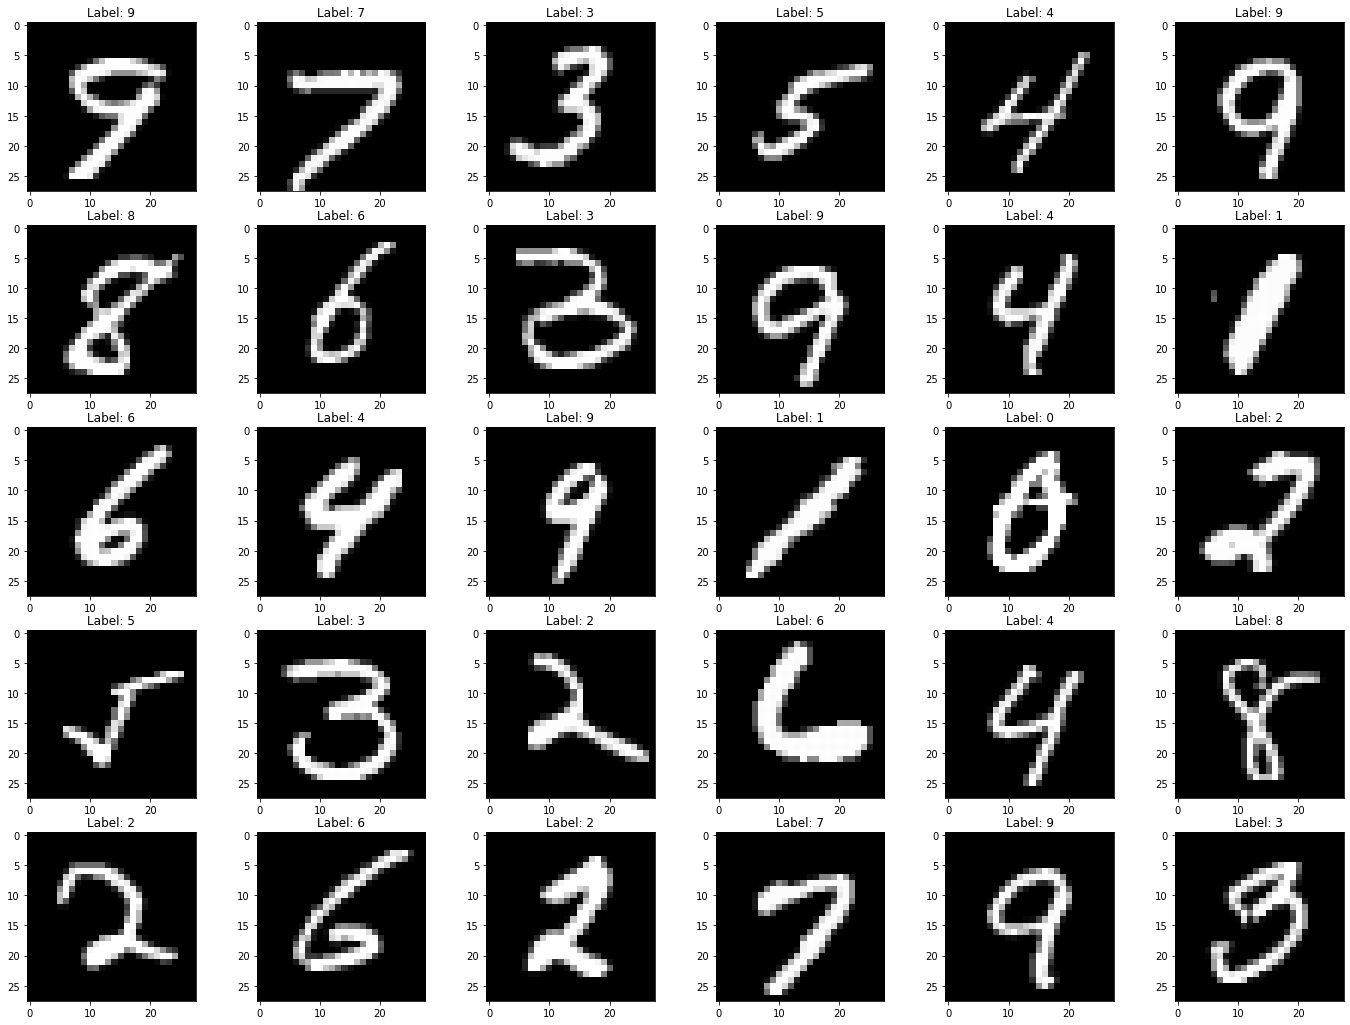

In [6]:
# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_dev.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [10]:
# Randomly shffling samples equally across samples
r,c = np.indices( (X_dev.shape[1:]) )
np.random.shuffle(r)
np.random.shuffle(c)
X_dev = X_dev[:,r,c]
X_test = X_test[:,r,c]

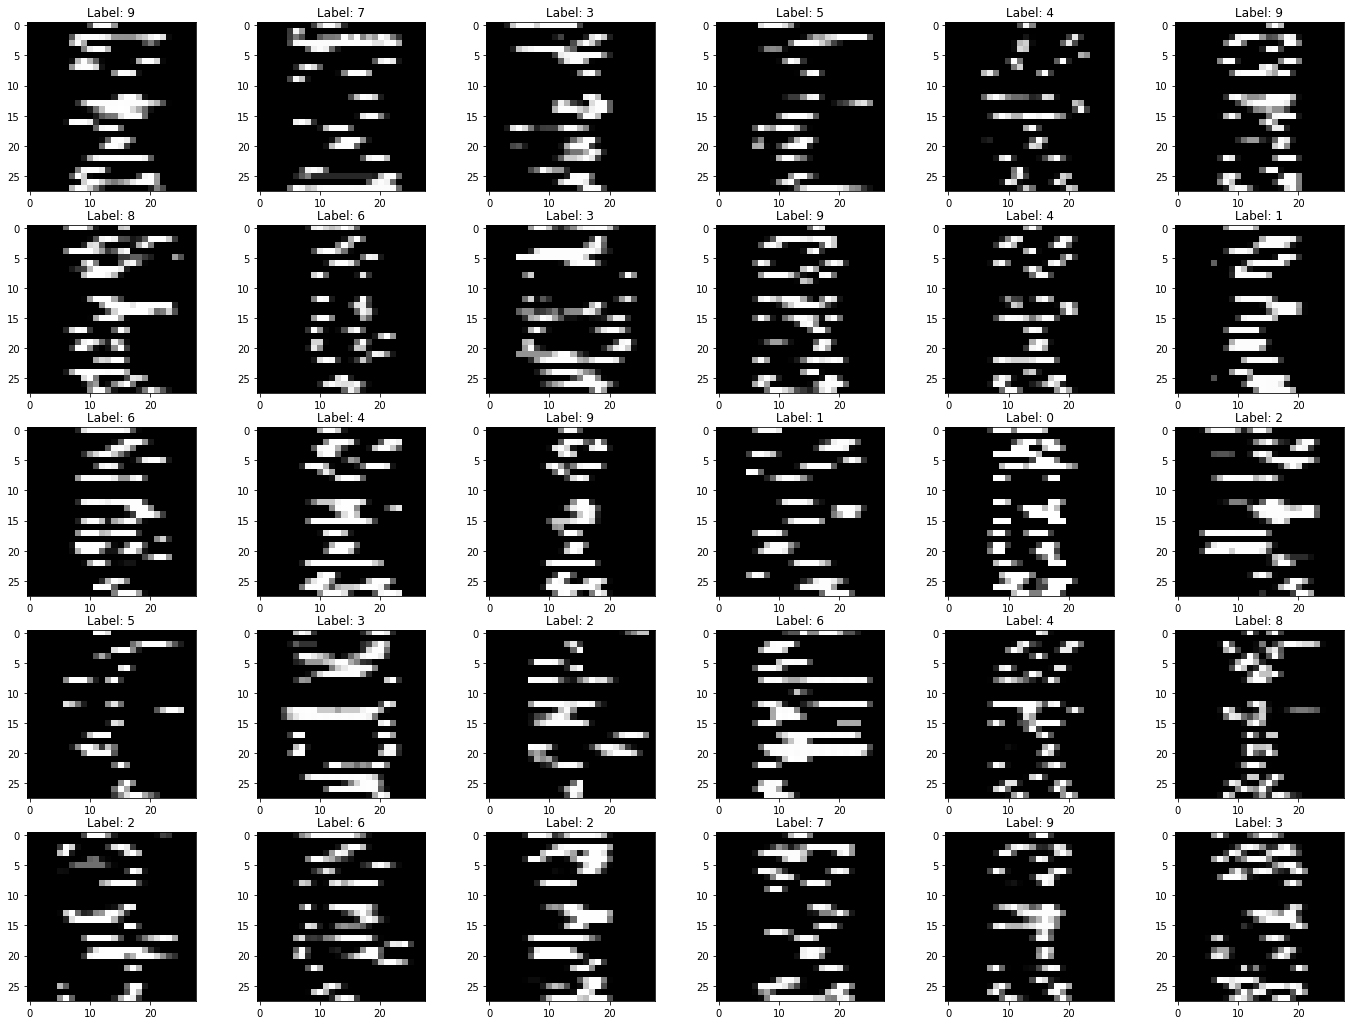

In [11]:
# Disaplying some samples from the development set after shuffling
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_dev[jj], cmap = "gray")
    plt.title("Label: %d" %Y_dev[jj])
plt.show()

In [12]:
#The number of classes across samples looks balanced
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) # Train/validation split

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (45000, 28, 28)
Labels shape:  (45000,)

Validation set
Images:  (15000, 28, 28)
Labels shape:  (15000,)


In [13]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 33.31474044784581 78.5647702708273
0 255 33.329464455782315 78.57564752163664


## 2. Data Scaling 

In [14]:
norm_type = 0 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass

## 3. One hot encoding

In [15]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)
Y_test_oh = tf.keras.utils.to_categorical(Y_test)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[4 3 1 5 6]

One hot encoded labels:
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


## 4. Define your model, cost function, optimizer, learning rate

In [16]:
def my_model(ishape = (28,28),k = 10, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(model_input_flatten)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [17]:
model = my_model()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


## 5. Define your callbacks (save your model, patience, etc.)

- [Keras callbacks](https://keras.io/api/callbacks/)

In [18]:
model_name = "best_model_mnist.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 6. Train your model

In [19]:
model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 1000, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

Epoch 1/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 1.5571 - accuracy: 0.6139 - val_loss: 1.0945 - val_accuracy: 0.7905 - lr: 5.0000e-05
Epoch 2/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.9019 - accuracy: 0.8190 - val_loss: 0.7520 - val_accuracy: 0.8407 - lr: 5.0000e-05
Epoch 3/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.6730 - accuracy: 0.8511 - val_loss: 0.6036 - val_accuracy: 0.8617 - lr: 5.0000e-05
Epoch 4/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.5615 - accuracy: 0.8672 - val_loss: 0.5226 - val_accuracy: 0.8735 - lr: 5.0000e-05
Epoch 5/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.4969 - accuracy: 0.8781 - val_loss: 0.4727 - val_accuracy: 0.8805 - lr: 5.0000e-05
Epoch 6/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.4555 - accuracy: 0.8843 - val_loss: 0.4396 - val_accuracy: 0.8867 - lr: 5.0000e-05
Epoch 7/1000
1407/1407

1407/1407 [==============================] - 2s 1ms/step - loss: 0.3194 - accuracy: 0.9115 - val_loss: 0.3241 - val_accuracy: 0.9105 - lr: 1.5625e-06
Epoch 52/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3193 - accuracy: 0.9116 - val_loss: 0.3240 - val_accuracy: 0.9107 - lr: 1.5625e-06
Epoch 53/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3193 - accuracy: 0.9116 - val_loss: 0.3239 - val_accuracy: 0.9108 - lr: 1.5625e-06
Epoch 54/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3192 - accuracy: 0.9116 - val_loss: 0.3238 - val_accuracy: 0.9107 - lr: 1.5625e-06
Epoch 55/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3191 - accuracy: 0.9117 - val_loss: 0.3237 - val_accuracy: 0.9107 - lr: 1.5625e-06
Epoch 56/1000
1407/1407 [==============================] - 2s 1ms/step - loss: 0.3190 - accuracy: 0.9117 - val_loss: 0.3236 - val_accuracy: 0.9107 - lr: 1.5625e-06
Epoch 57/1000
1407/1407 [=====

KeyboardInterrupt: 

## 7. Test your model on the test and extract relevant metrics

In [20]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test_oh)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

313/313 [==============================] - 0s 841us/step - loss: 0.3091 - accuracy: 0.9157
Categorical cross-entropy: 0.309135377407074
Accuracy: 0.9157000184059143


843


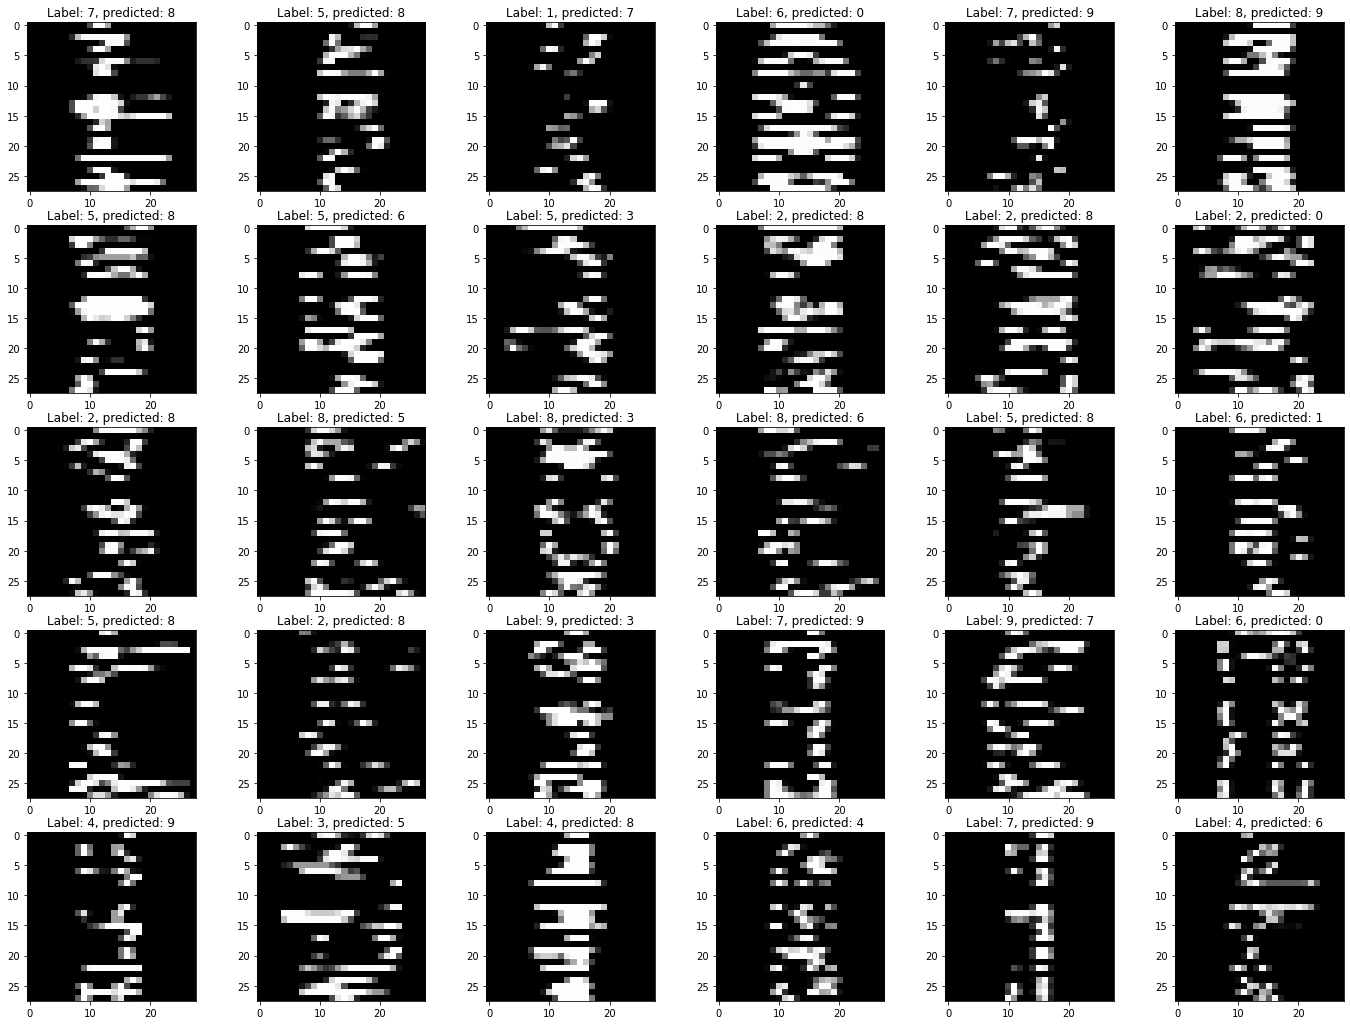

In [21]:
Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## (Optional) Displaying the weights of the layers as images

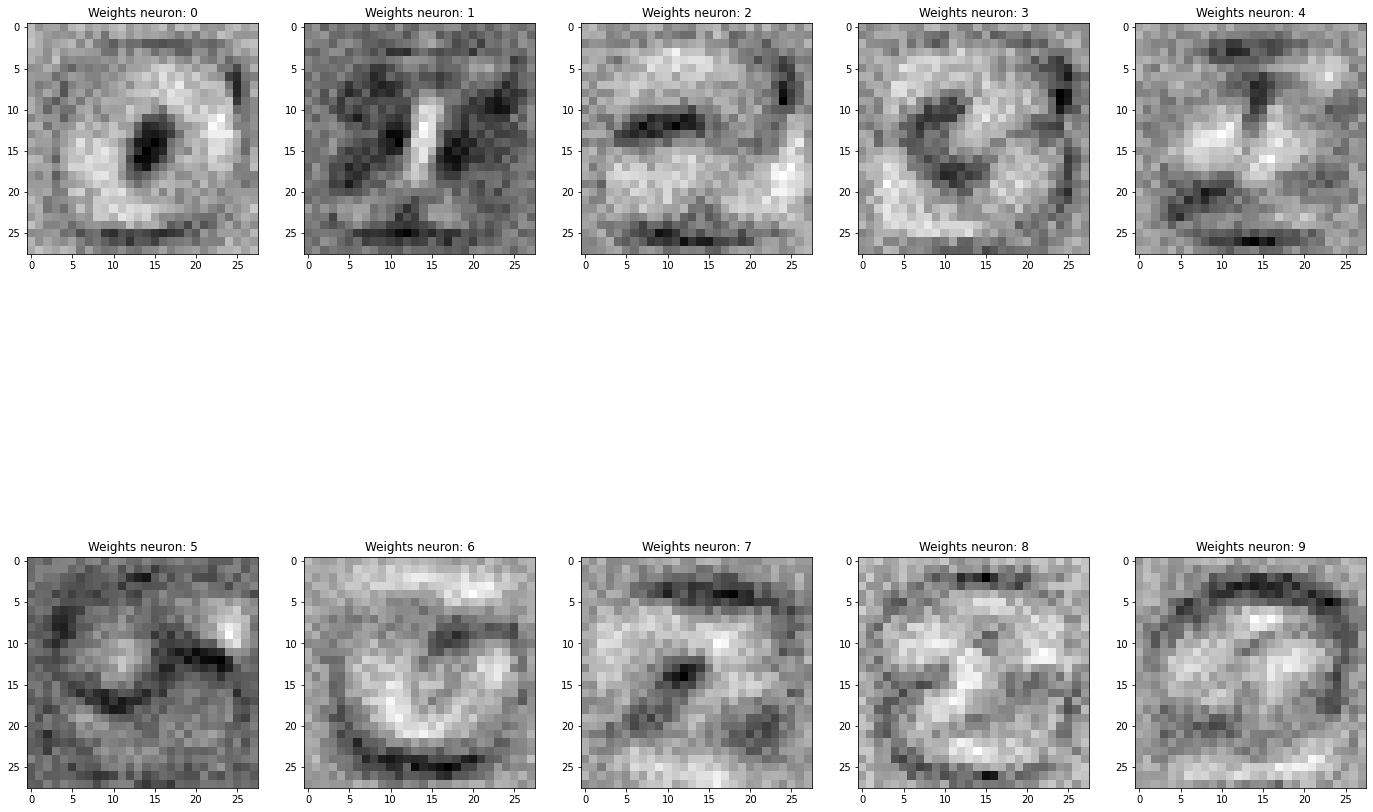

In [15]:
weights = model.get_weights()
plt.figure(figsize = (24,18))
for ii in range(10):
    plt.subplot(2,5,ii+1)
    plt.imshow(weights[0][:,ii].reshape(28,28), cmap = "gray")
    plt.title("Weights neuron: %d" %(ii))
plt.show()